In [234]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from Net.experiments.main_experiment import TrainExperiment, TrainExperimentDetector, KP1, KP2, W_KP1, W_KP2, KP1_DESC, KP2_DESC, DESC1, DESC2, SCORE1, SCORE2
from Net.experiments.custom_experiments import DebugTrainExperiment
from Net.source.utils.common_utils import draw_cv_keypoints, torch2cv, plot_figures
from Net.source.utils.model_utils import sample_descriptors
from Net.source.utils.math_utils import calculate_inv_similarity_matrix, calculate_distance_matrix, calculate_inv_similarity_vector
from Net.source.utils.image_utils import warp_points, warp_image, filter_border, select_keypoints, gaussian_filter
from Net.source.utils.eval_utils import repeatability_score
from Net.source.hpatches_dataset import S_IMAGE1, S_IMAGE2, HOMO12, HOMO21

In [236]:
device = torch.device('cpu')

checkpoint_dir = "/home/konstantin/PycharmProjects/Summertime/Net/checkpoints/det_lr0.0001"

experiment = TrainExperimentDetector(device, None, checkpoint_dir, 100)

In [237]:
batch = experiment.analyze_inference()

In [252]:
s_image1 = batch[S_IMAGE1]
s_image2 = batch[S_IMAGE2]

kp1 = batch[KP1]
kp2 = batch[KP2]

w_kp1 = batch[W_KP1]
w_kp2 = batch[W_KP2]

score1 = batch[SCORE1]
score2 = batch[SCORE2]

homo12 = batch[HOMO12]

In [239]:
cv_s_image1 = torch2cv(s_image1.squeeze(0))
cv_s_image2 = torch2cv(s_image2.squeeze(0))

cv_kp1_image1 = draw_cv_keypoints(cv_s_image1, kp1.squeeze(0), (0, 255, 0))
cv_score1 = cv2.cvtColor(torch2cv(score1.squeeze(0) / score1.max()), cv2.COLOR_GRAY2RGB)

cv_kp2_image2 = draw_cv_keypoints(cv_s_image2, kp2.squeeze(0), (0, 255, 0))
cv_score2 = cv2.cvtColor(torch2cv(score2.squeeze(0) / score2.max()), cv2.COLOR_GRAY2RGB)

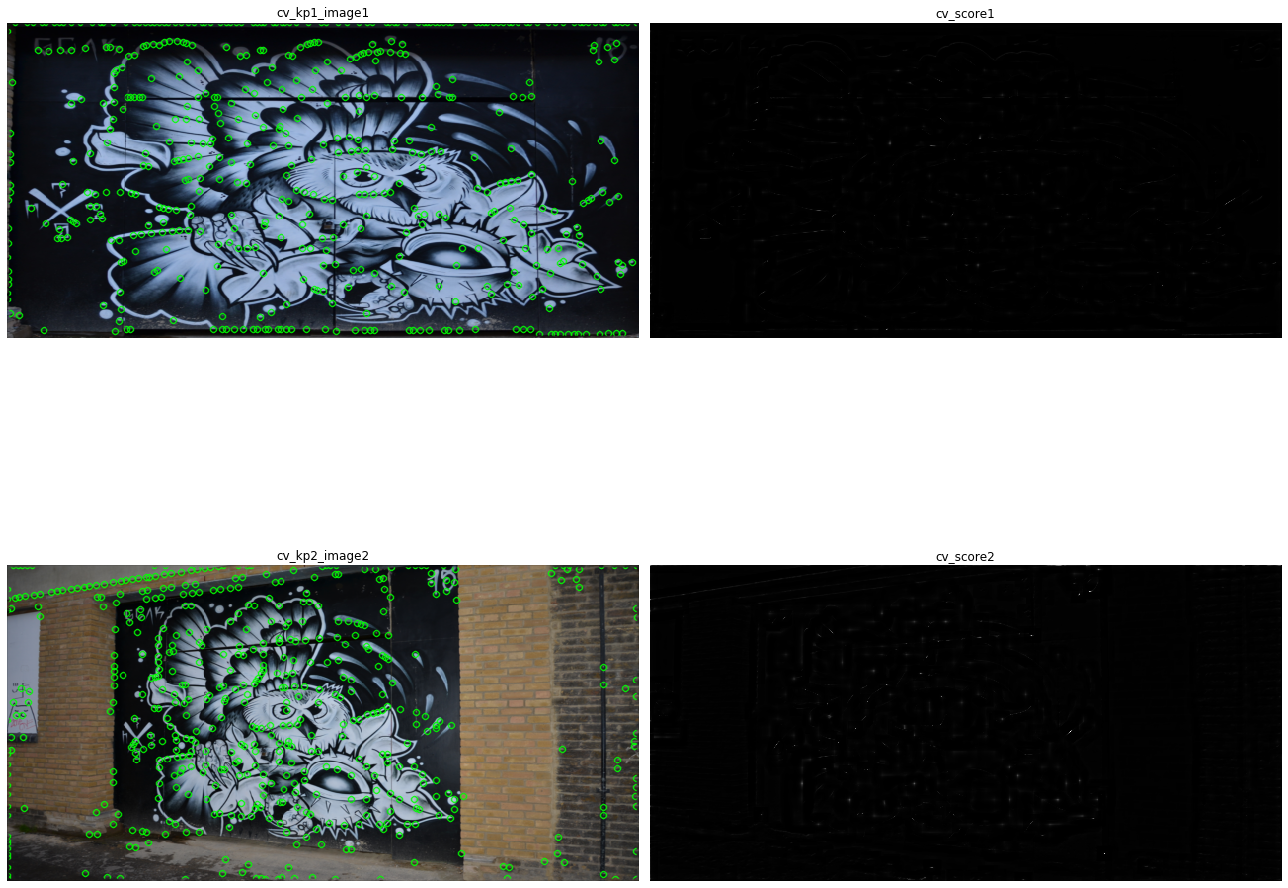

In [240]:
plot_figures({'cv_kp1_image1': cv_kp1_image1,
              'cv_score1': cv_score1,
              'cv_kp2_image2': cv_kp2_image2,
              'cv_score2': cv_score2}, 2, 2, (18, 18))

In [241]:
f_score1 = filter_border(score1)
f_score2 = filter_border(score2)

In [242]:
cv_f_score1 = cv2.cvtColor(torch2cv(f_score1.squeeze(0) / f_score1.max()), cv2.COLOR_GRAY2RGB)
cv_f_score2 = cv2.cvtColor(torch2cv(f_score2.squeeze(0) / f_score2.max()), cv2.COLOR_GRAY2RGB)

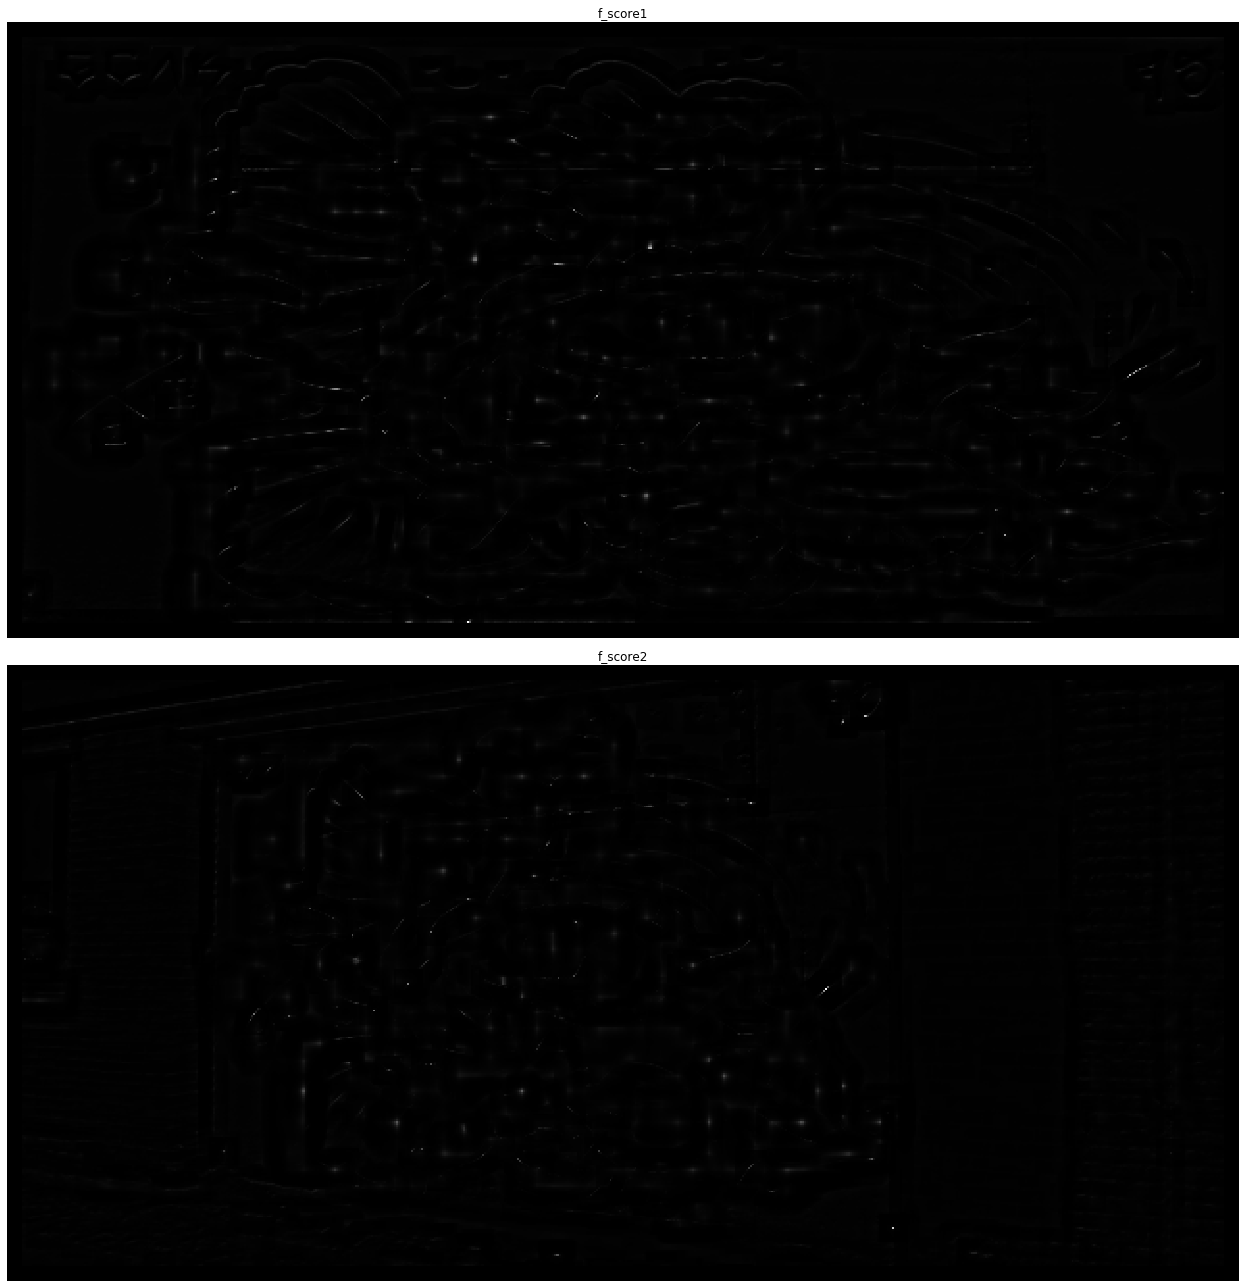

In [243]:
plot_figures({'f_score1': cv_f_score1,
              'f_score2': cv_f_score2}, 2, 1, (18, 18))

In [244]:
w_f_score2 = filter_border(warp_image(f_score1, f_score2, homo12))

In [245]:
cv_f_v_score2 = cv2.cvtColor(torch2cv(w_f_score2.squeeze(0) / w_f_score2.max()), cv2.COLOR_GRAY2RGB)

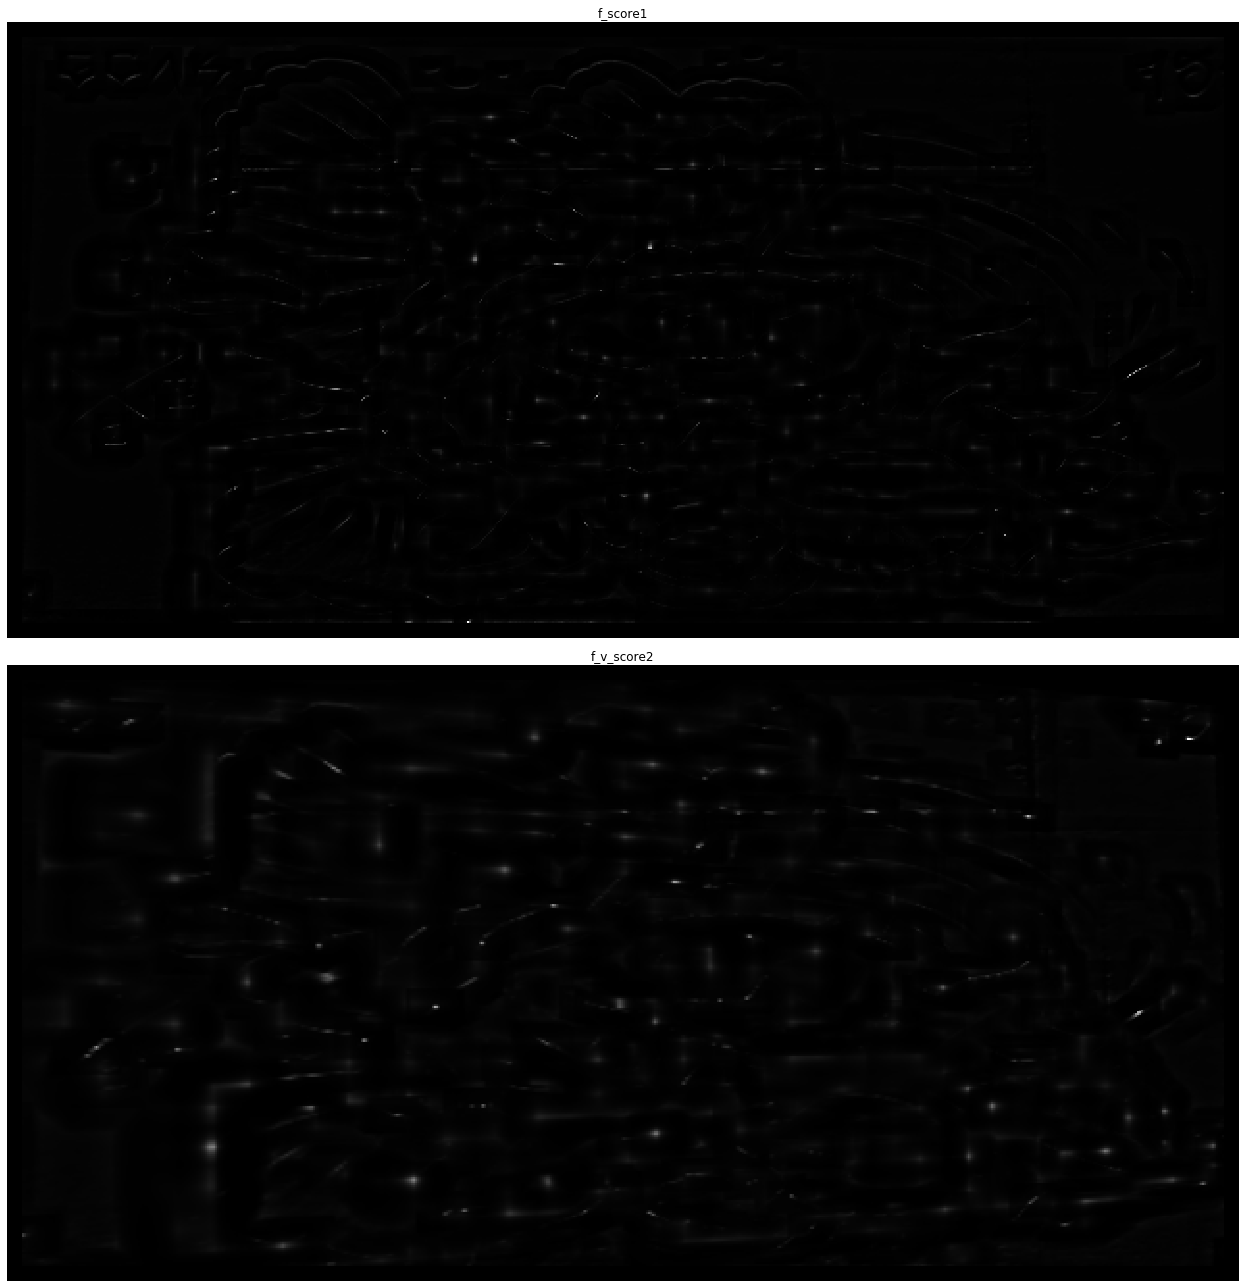

In [246]:
plot_figures({'f_score1': cv_f_score1,
              'f_v_score2': cv_f_v_score2}, 2, 1, (18, 18))

In [261]:
_, f_kp1 = select_keypoints(f_score1, 0, 5, 512)
_, w_f_kp2 = select_keypoints(w_f_score2, 0, 5, 512)

In [262]:
repeatability_score(kp1, w_f_kp2, w_f_kp2, 512, 5)[0]

tensor(0.3535)

In [180]:
# cv_score1 = cv2.cvtColor(torch2cv(t_score1.squeeze(0) / score1.max()), cv2.COLOR_GRAY2RGB)
# cv_gt_score1 = cv2.cvtColor(torch2cv(gt_score1.squeeze(0) / gt_score1.max()), cv2.COLOR_GRAY2RGB)
# cv_loss = cv2.cvtColor(torch2cv(loss.squeeze(0) / loss.max()), cv2.COLOR_GRAY2RGB)

In [181]:
# plot_figures({'cv_score1': cv_score1,
#               'cv_gt_score1': cv_gt_score1,
#               'cv_loss': cv_loss}, 3, 1, (18, 18))

In [ ]:

# # TODO. Gaussian blurring?
# t_score1 = filter_border(score1)
# w_score2 = filter_border(w_score2)

# # Create visibility mask of the first image
# w_vis_mask = warp_image(score1, torch.ones_like(score2).to(score2.device), homo12).gt(0).float()

# gt_score1, _ = select_keypoints(w_score2, 0, 5, 512)
# gt_score1 = gaussian_filter(gt_score1, 5, 0.5)

# loss = F.mse_loss(t_score1, gt_score1, reduction='none')

# print(loss.sum())
# print(t_score1.sum())
# print(gt_score1.sum())